<a href="https://colab.research.google.com/github/smalaboy/wikipedia-articles-quality-ratings-prediction/blob/main/big_data_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up Spark environment**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
# Install textstat package for features extraction
!pip install textstat

     |████████████████████████████████| 105 kB 8.7 MB/s 
     |████████████████████████████████| 2.0 MB 11.2 MB/s 


**Extracting and loading the dataset plus preprocessing**

In [ ]:

!tar -xf '/content/drive/MyDrive/Big data project/dataset/2017_english_wikipedia_quality_dataset.tar.bz2'

In [ ]:
!head datasets/training-set.tsv

article_pageid	article_revid	talk_pageid	talk_revid	rating
40452915	114890603	6571443	115289309	FA
1411100	146756677	4408065	146854799	FA
29594	661234581	29595	661615181	FA
61075	51180276	3912707	51473626	FA
27972897	417340888	28703029	417340981	FA
773871	393596548	11225839	393596569	FA
977013	599919345	6388819	600044050	FA
44371	194070822	602518	194070829	FA
4582725	225485546	5033259	226151081	FA


In [ ]:
# Training grades
training_grades_rdd = spark.sparkContext.textFile("datasets/training-set.tsv").map(lambda line: line.split("\t"))
training_grades_rdd.take(5)

[['article_pageid', 'article_revid', 'talk_pageid', 'talk_revid', 'rating'],
 ['40452915', '114890603', '6571443', '115289309', 'FA'],
 ['1411100', '146756677', '4408065', '146854799', 'FA'],
 ['29594', '661234581', '29595', '661615181', 'FA'],
 ['61075', '51180276', '3912707', '51473626', 'FA']]

In [ ]:
training_grades_rdd.groupBy(lambda x: x[0]).count()

29175

In [ ]:
header = ["article_pageid", "article_revid", "talk_pageid", "talk_revid", "rating"]

In [ ]:
# Removing header row and loading into a Spark Dataframe
training_ratings_df = training_grades_rdd.filter(lambda row: row != header).toDF(schema=header)
training_ratings_df.printSchema()
training_ratings_df.head(5)

root
 |-- article_pageid: string (nullable = true)
 |-- article_revid: string (nullable = true)
 |-- talk_pageid: string (nullable = true)
 |-- talk_revid: string (nullable = true)
 |-- rating: string (nullable = true)



[Row(article_pageid='40452915', article_revid='114890603', talk_pageid='6571443', talk_revid='115289309', rating='FA'),
 Row(article_pageid='1411100', article_revid='146756677', talk_pageid='4408065', talk_revid='146854799', rating='FA'),
 Row(article_pageid='29594', article_revid='661234581', talk_pageid='29595', talk_revid='661615181', rating='FA'),
 Row(article_pageid='61075', article_revid='51180276', talk_pageid='3912707', talk_revid='51473626', rating='FA'),
 Row(article_pageid='27972897', article_revid='417340888', talk_pageid='28703029', talk_revid='417340981', rating='FA')]

**Ratings extraction**

In [ ]:
def extract_rating_todf(filename: str):
  header = ["article_pageid", "article_revid", "talk_pageid", "talk_revid", "rating"]
  ratings_rdd = spark.sparkContext.textFile(f"{filename}").map(lambda line: line.split("\t"))
  ratings_df = ratings_rdd.filter(lambda row: row != header).toDF(schema=header)
  return ratings_df

In [ ]:
training_rating_df = extract_rating_todf("datasets/training-set.tsv")
test_rating_df = extract_rating_todf("datasets/test-set.tsv")
rating_df = training_rating_df.union(test_rating_df)
rating_df.head(5)

[Row(article_pageid='40452915', article_revid='114890603', talk_pageid='6571443', talk_revid='115289309', rating='FA'),
 Row(article_pageid='1411100', article_revid='146756677', talk_pageid='4408065', talk_revid='146854799', rating='FA'),
 Row(article_pageid='29594', article_revid='661234581', talk_pageid='29595', talk_revid='661615181', rating='FA'),
 Row(article_pageid='61075', article_revid='51180276', talk_pageid='3912707', talk_revid='51473626', rating='FA'),
 Row(article_pageid='27972897', article_revid='417340888', talk_pageid='28703029', talk_revid='417340981', rating='FA')]

**File data extraction**

In [ ]:
def extract_file_text_data(filename: str):
  """
  Reads the file and returns the text data
  """
  text = ""
  with open(filename, "r") as f:
    text = f.read()
  return text

In [ ]:
def text_length_in_bytes(text: str):
  """
  Returns the file length in bytes
  """
  return len(text.encode('utf-8'))

In [ ]:
import re
import textstat
import math

features_list = ["content_length", "n_words", "num_references", "num_page_links", "num_categories", "num_images_length", "has_infobox",
                  "flesch_reading_ease", "flesch_kincaid_grade", "smog_index", "coleman_liau_index", "automated_readability_index", "difficult_words",
                 "dale_chall_readability_score", "linsear_write_formula", "gunning_fog",  "num_lv2_headings", "num_lv3_headings"
                 ,"avg_word", "words_per_sent", "nb_lang", "nb_info_items", "nb_lead_paragraphs"]

def extract_text_data_features_todf(text: str):
  """
  Extracts the features from text data and returns an order list of the values
  """
  content_length = text_length_in_bytes(text)  # Article length in bytes OK
  n_words = 0 # Number of words
  num_references = 0  # Number of references OK
  num_page_links = 0  # Number of outlinks to other Wikipedia pages OK
  # num_cite_temp = 0  # Number of citation templates
  # num_non_cite_templates = 0  # Number of non-citation templates
  num_categories = 0  # Number of categories linked in the text OK
  _num_images = 0  # Number of images
  num_images_length = 0  # Number of images / length of article OK
  has_infobox = 0  # Article has an infobox or not  OK
  num_lv2_headings = 0  # Number of level 2 headings
  num_lv3_headings = 0  # Number of level 3+ headings

  flesch_reading_ease = textstat.flesch_reading_ease(text)  # Flesch reading score
  flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)  # Flesch-Kincaid grade level
  smog_index = textstat.smog_index(text)  # Smog index
  coleman_liau_index = textstat.coleman_liau_index(text)  # Coleman-Liau index
  automated_readability_index = textstat.automated_readability_index(text)  # Automated readability index
  difficult_words = textstat.difficult_words(text)  # Difficult words
  dale_chall_readability_score = textstat.dale_chall_readability_score(text)  # Dale-Chall score
  linsear_write_formula = textstat.linsear_write_formula(text)  # Linsear write formula
  gunning_fog = textstat.gunning_fog(text)  # Gunning-Fog index

  avg_word = textstat.avg_letter_per_word(text)
  words_per_sent = textstat.avg_sentence_length(text)
  nb_lang = 0
  nb_info_items = 0
  nb_lead_paragraphs = 0

  text_lines = str(text).splitlines()
  n = len(text_lines)

  for i in range(len(text_lines)):
    line = text_lines[i] # Current line

    # Counting the number of words
    n_words += len(str(line).strip().split(' '))

    # Number of paragraphs of the lead section
    # if re.search("^([^\{\}\|=]|[a-zA-Z0-9\'])", line) and nb_lead_paragraphs == 0 and len(line.strip()) > 0:
    if re.search("^([a-zA-Z0-9\'])", line) and nb_lead_paragraphs == 0 and len(line.strip()) > 0:
      nb_lead_paragraphs += 1
      next_line = text_lines[i+1] if (i+1) < len(text_lines) else ''
      while not re.search("^={2}", next_line) and i < n:
        if len(next_line.strip()) > 0:
          nb_lead_paragraphs += 1
        i += 1
        next_line = text_lines[i+1] if (i+1) < len(text_lines) else ''


    # Counting the number of l2 level titles
    if re.search("^={2}[^=].*[^=]={2}$", line):
      num_lv2_headings += 1

    # Counting the number of l3 level titles
    if re.search("^={3}.*={3}$", line):
      num_lv3_headings += 1

    # Checking for the presence of an infobox and counting the number info lines
    # if line.startswith("{{Infobox"):
    if re.search("^{{.*Infobox", line, re.IGNORECASE):
      has_infobox += 1
      # nb_info_items = 0
      next_line = text_lines[i+1] if (i+1) < len(text_lines) else ''
      while not re.search("^[^\{\{].*}}", next_line) and i < n: # While closing brackets are not matched
        nb_info_items += 1
        i += 1
        next_line = text_lines[i+1] if (i+1) < len(text_lines) else ''

    # Counting the number of references (num_references)
    if line.strip().startswith("==References==") or line.strip().startswith("== References ==") or line.strip().startswith("==Sources==") or line.strip().startswith("== Sources =="):
      next_line = text_lines[i+1] if (i+1) < len(text_lines) else ''
      while not next_line.startswith("==") and len(next_line.strip())>0 and i < n:
        num_references += 1 if next_line.startswith("*") else 0
        i += 1
        next_line = text_lines[i+1] if (i+1) < len(text_lines) else ''

    # Counting the number of links to wikipedia pages (num_page_links)
    if line.strip().startswith("==See also==") or line.strip().startswith("== See also =="):
      next_line = text_lines[i+1] if (i+1) < len(text_lines) else ''
      # while next_line.startswith("*"):
      while not next_line.startswith("==") and len(next_line.strip())>0 and i < n:
        num_page_links += 1 if next_line.startswith("*") else 0
        i += 1
        next_line = text_lines[i+1] if (i+1) < len(text_lines) else ''

    # Counting the number of categories linked in the text
    if line.startswith("[[Category:"):
      num_categories += 1

    # Counting the number of images
    # if line.startswith("[[Image:"):
    if re.search("^.*\[\[Image", line, re.IGNORECASE):
      _num_images += 1

    # count the number of different languages except english
    if re.search("^\[\[[a-zA-Z]{2,3}:.*\]\]$", line, re.IGNORECASE):
      nb_lang += 1

  num_images_length = _num_images / content_length
  num_images_length = math.log(num_images_length + 1)
  content_length = math.log(content_length + 1)
  num_references = math.log(num_references + 1)

  # For visualisation. Not used
  out_dict = {
      "content_length": float(content_length),
      "n_words": float(n_words),
      "num_references": float(num_references),
      "num_page_links": float(num_page_links),
      "num_categories": float(num_categories),
      "num_images_length": float(num_images_length),
      "has_infobox": float(has_infobox),
      "flesch_reading_ease": float(flesch_reading_ease),
      "flesch_kincaid_grade": float(flesch_kincaid_grade),
      "smog_index": float(smog_index),
      "coleman_liau_index": float(coleman_liau_index),
      "automated_readability_index": float(automated_readability_index),
      "difficult_words": float(difficult_words),
      "dale_chall_readability_score": float(dale_chall_readability_score),
      "linsear_write_formula": float(linsear_write_formula),
      "gunning_fog": float(gunning_fog),
      "num_lv2_headings": float(num_lv2_headings),
      "num_lv3_headings": float(num_lv3_headings),

      "avg_word": avg_word,
      "words_per_sent": words_per_sent,
      "nb_lang": nb_lang,
      "nb_info_items": nb_info_items,
      "nb_lead_paragraphs": nb_lead_paragraphs
  }
  # print(out_dict)

  return list(map(float, [content_length, n_words, num_references, num_page_links, num_categories, num_images_length, has_infobox,
                          flesch_reading_ease, flesch_kincaid_grade, smog_index, coleman_liau_index, automated_readability_index, difficult_words,
                          dale_chall_readability_score, linsear_write_formula, gunning_fog, num_lv2_headings, num_lv3_headings
                          ,avg_word, words_per_sent, nb_lang, nb_info_items, nb_lead_paragraphs]))


In [ ]:
# Test
# extract_text_data_features_todf(extract_file_text_data("revisiondata/50519644"))
# extract_text_data_features_todf(extract_file_text_data("revisiondata/46372253"))
# extract_text_data_features_todf(extract_file_text_data("revisiondata/720901161"))

Extracting features from the dataset and loading into a dataframe

In [ ]:
import os
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.types import StructField, StringType, StructType, IntegerType, DoubleType, ArrayType

schema = StructType([ \
    StructField("index", IntegerType(), True), \
    StructField("article_revid",StringType(),True), \
    StructField("features", ArrayType(DoubleType()),True), \
    # StructField("rating",StringType(),True), \
  ] + [StructField(field_name, DoubleType(), True) for field_name in features_list])
data = []
for index, file_name in enumerate(os.listdir("revisiondata")):
  if index % 100 == 0:  # Prints the progress
      print(f"{index} - {file_name}")
  features = extract_text_data_features_todf(extract_file_text_data(f"revisiondata/{file_name}"))
  row = []
  row.append(index)
  row.append(file_name)
  row.append(features)

  for value in features:
    row.append(value)

  data.append(row)

# print(data[:5])

df = spark.createDataFrame(data, schema=schema)
df.printSchema()
df.head(5)

0 - 276734636
100 - 93924707
200 - 607075256
300 - 261637205
400 - 464490188
500 - 230532762
600 - 340988465
700 - 529680051
800 - 579124903
900 - 121452470
1000 - 430189952
1100 - 615466514
1200 - 116391100
1300 - 204702899


KeyboardInterrupt: ignored

In [ ]:
# Persisting the processed features
df.write.json("/content/drive/MyDrive/Big data project/dataset/processed_dataset_w_features_json6")

In [ ]:
from pyspark.sql.functions import udf

def quality_level(rating):
  """
  Converts the rating to High or Low and returns the value
  """
  if rating in ["FA", "GA"]:
    return "High"
  return "Low"

# User defined function to automaticaly add the quality level
quality_level_udf=udf(quality_level)

Joining the extracted features with the grades, the revision id

In [ ]:
#Joining the extracted features with the grades, the revision id
full_df = df.join(rating_df, df.article_revid==rating_df.article_revid).select(["index", df.article_revid, "article_pageid", "talk_pageid", "talk_revid", rating_df.rating, "features"] + features_list)
full_df = full_df.withColumn("quality", quality_level_udf(full_df.rating))
training_df = df.join(training_rating_df, df.article_revid==training_rating_df.article_revid).select(["index", df.article_revid, "article_pageid", "talk_pageid", "talk_revid", training_rating_df.rating, "features"] + features_list)
training_df = training_df.withColumn("quality", quality_level_udf(training_df.rating))
testing_df = df.join(test_rating_df, df.article_revid==test_rating_df.article_revid).select(["index", df.article_revid, "article_pageid", "talk_pageid", "talk_revid", test_rating_df.rating, "features"] + features_list)
testing_df = testing_df.withColumn("quality", quality_level_udf(testing_df.rating))
full_df.printSchema()
full_df.head(5)

root
 |-- index: integer (nullable = true)
 |-- article_revid: string (nullable = true)
 |-- article_pageid: string (nullable = true)
 |-- talk_pageid: string (nullable = true)
 |-- talk_revid: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- content_length: double (nullable = true)
 |-- n_words: double (nullable = true)
 |-- num_references: double (nullable = true)
 |-- num_page_links: double (nullable = true)
 |-- num_categories: double (nullable = true)
 |-- num_images_length: double (nullable = true)
 |-- has_infobox: double (nullable = true)
 |-- flesch_reading_ease: double (nullable = true)
 |-- flesch_kincaid_grade: double (nullable = true)
 |-- smog_index: double (nullable = true)
 |-- coleman_liau_index: double (nullable = true)
 |-- automated_readability_index: double (nullable = true)
 |-- difficult_words: double (nullable = true)
 |-- dale_chall_readability_score: doubl

[Row(index=96, article_revid='687110171', article_pageid='44839612', talk_pageid='44842259', talk_revid='709521001', rating='B', features=[9.261413642160184, 1464.0, 0.0, 0.0, 10.0, 0.0, 1.0, 25.8, 14.6, 16.2, 18.56, 21.8, 247.0, 9.29, 22.333333333333332, 12.35, 2.0, 0.0, 6.18, 20.0, 0.0, 7.0, 1.0], content_length=9.261413642160184, n_words=1464.0, num_references=0.0, num_page_links=0.0, num_categories=10.0, num_images_length=0.0, has_infobox=1.0, flesch_reading_ease=25.8, flesch_kincaid_grade=14.6, smog_index=16.2, coleman_liau_index=18.56, automated_readability_index=21.8, difficult_words=247.0, dale_chall_readability_score=9.29, linsear_write_formula=22.333333333333332, gunning_fog=12.35, num_lv2_headings=2.0, num_lv3_headings=0.0, avg_word=6.18, words_per_sent=20.0, nb_lang=0.0, nb_info_items=7.0, nb_lead_paragraphs=1.0, quality='Low'),
 Row(index=173, article_revid='276553443', article_pageid='3066317', talk_pageid='10037044', talk_revid='276557527', rating='GA', features=[9.53082

In [ ]:
# Persisting the extracted features with their respective grades for further reuse
full_df.write.json("/content/drive/MyDrive/Big data project/dataset/full_dataset_w_features_json6")
training_df.write.json("/content/drive/MyDrive/Big data project/dataset/training_dataset_w_features_json6")
testing_df.write.json("/content/drive/MyDrive/Big data project/dataset/test_dataset_w_features_json6")

Loading saved datasets

In [ ]:
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.types import StructField, StringType, StructType, IntegerType, DoubleType, ArrayType

schema = StructType([ \
    StructField("index", IntegerType(), True), \
    StructField("article_revid",StringType(),True), \
    StructField("features", ArrayType(DoubleType()),True), \
    # StructField("rating",StringType(),True), \
  ] + [StructField(field_name, DoubleType(), True) for field_name in features_list])
full_df = spark.read.json("/content/drive/MyDrive/Big data project/dataset/full_dataset_w_features_json6")
training_df = spark.read.json("/content/drive/MyDrive/Big data project/dataset/training_dataset_w_features_json6")
testing_df = spark.read.json("/content/drive/MyDrive/Big data project/dataset/test_dataset_w_features_json6")

In [ ]:
# print(df.count())
# print(training_rating_df.count())
print(training_df.count())
print(testing_df.count())
print(full_df.count())
# print(rating_df.count())

29174
3286
32460


In [ ]:
full_df.groupBy("rating").count().collect()

[Row(rating='Stub', count=5493),
 Row(rating='B', count=5492),
 Row(rating='C', count=5492),
 Row(rating='Start', count=5490),
 Row(rating='FA', count=4996),
 Row(rating='GA', count=5497)]

In [ ]:
training_df.groupBy("rating").count().collect()

[Row(rating='Stub', count=4914),
 Row(rating='B', count=4945),
 Row(rating='C', count=4936),
 Row(rating='Start', count=4939),
 Row(rating='FA', count=4492),
 Row(rating='GA', count=4948)]

In [ ]:
testing_df.groupBy("rating").count().collect()

[Row(rating='Stub', count=579),
 Row(rating='B', count=547),
 Row(rating='C', count=556),
 Row(rating='Start', count=551),
 Row(rating='FA', count=504),
 Row(rating='GA', count=549)]

In [ ]:
full_df.groupBy("quality").count().collect()

[Row(quality='High', count=10493), Row(quality='Low', count=21967)]

In [ ]:
training_df.groupBy("quality").count().collect()

[Row(quality='High', count=9440), Row(quality='Low', count=19734)]

In [ ]:
testing_df.groupBy("quality").count().collect()

[Row(quality='High', count=1053), Row(quality='Low', count=2233)]

In [ ]:
# Plot histogram
import matplotlib.pyplot as plt
def plot_histogram(items_list, title="Histogram", xlabel="Rating", ylabel="Value"):
  """
  Takes a list of tuples (rating, value) and plots the corresponding histogram
  """
  plt.figure()
  items_list_ = [(row.rating, row[1]) for row in items_list]
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.bar([x[0] for x in items_list_], [x[1] for x in items_list_])
  plt.savefig(title.replace(" ", "_").lower())
  plt.show()

**Mean of the articles content byte length grouped by rating.**

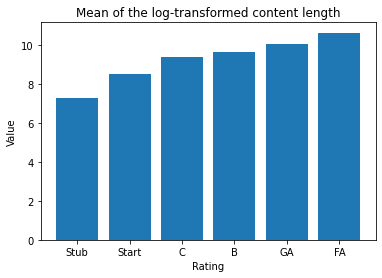

In [ ]:
from pyspark.sql import functions as F
content_min_mean_max_df = full_df.groupBy("rating").agg(F.min(full_df.content_length), F.avg(full_df.content_length), F.max(full_df.content_length)).orderBy("avg(content_length)")
# content_min_mean_max_df.toPandas()
_content_mean = content_min_mean_max_df.select("rating", "avg(content_length)").collect()
plot_histogram(_content_mean, title="Mean of the log-transformed content length", xlabel="Rating", ylabel="Value")

**Mean count of words of the articles content grouped by rating.**

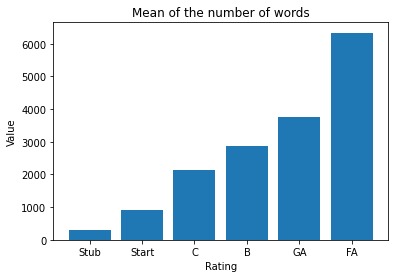

In [ ]:
from pyspark.sql import functions as F
nwords_min_mean_max_df = full_df.groupBy("rating").agg(F.min(full_df.n_words), F.avg(full_df.n_words), F.max(full_df.n_words)).orderBy("avg(n_words)")
# nwords_min_mean_max_df.toPandas()
_nwords_mean = nwords_min_mean_max_df.select("rating", "avg(n_words)").collect()
plot_histogram(_nwords_mean, title="Mean of the number of words", xlabel="Rating", ylabel="Value")

**Mean count of references of the articles grouped by rating.**

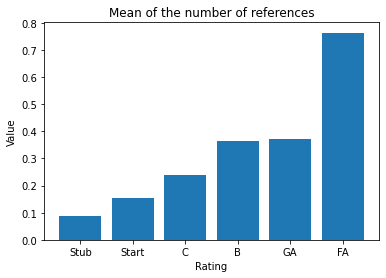

In [ ]:
from pyspark.sql import functions as F
nrefs_min_mean_max_df = full_df.groupBy("rating").agg(F.min(full_df.num_references), F.avg(full_df.num_references), F.max(full_df.num_references)).orderBy("avg(num_references)")
# nrefs_min_mean_max_df.toPandas()
_nrefs_mean = nrefs_min_mean_max_df.select("rating", "avg(num_references)").collect()
plot_histogram(_nrefs_mean, title="Mean of the number of references", xlabel="Rating", ylabel="Value")

**Mean count of the number of langauges per rating**

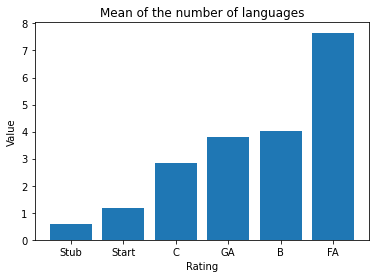

In [ ]:
from pyspark.sql import functions as F
nlang_min_mean_max_df = full_df.groupBy("rating").agg(F.min(full_df.nb_lang), F.avg(full_df.nb_lang), F.max(full_df.nb_lang)).orderBy("avg(nb_lang)")
# nlang_min_mean_max_df.toPandas()
_nlang_mean = nlang_min_mean_max_df.select("rating", "avg(nb_lang)").collect()
plot_histogram(_nlang_mean, title="Mean of the number of languages", xlabel="Rating", ylabel="Value")

**Mean count of the average word length per rating**

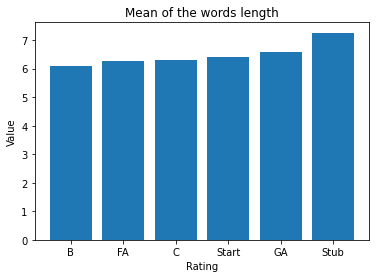

In [ ]:
from pyspark.sql import functions as F
avg_word_min_mean_max_df = full_df.groupBy("rating").agg(F.min(full_df.avg_word), F.avg(full_df.avg_word), F.max(full_df.avg_word)).orderBy("avg(avg_word)")
# avg_word_min_mean_max_df.toPandas()
_avg_word_mean = avg_word_min_mean_max_df.select("rating", "avg(avg_word)").collect()
plot_histogram(_avg_word_mean, title="Mean of the words length", xlabel="Rating", ylabel="Value")

**Average number of words per sentence**

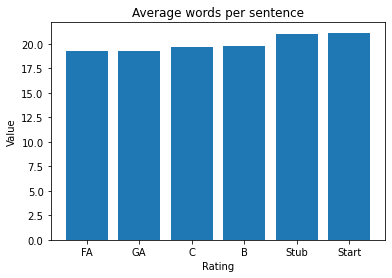

In [ ]:
from pyspark.sql import functions as F
words_per_sent_min_mean_max_df = full_df.groupBy("rating").agg(F.min(full_df.words_per_sent), F.avg(full_df.words_per_sent), F.max(full_df.words_per_sent)).orderBy("avg(words_per_sent)")
# words_per_sent_min_mean_max_df.toPandas()
_words_per_sent_mean = words_per_sent_min_mean_max_df.select("rating", "avg(words_per_sent)").collect()
plot_histogram(_words_per_sent_mean, title="Average words per sentence", xlabel="Rating", ylabel="Value")

**Average number of info lines in infobox**

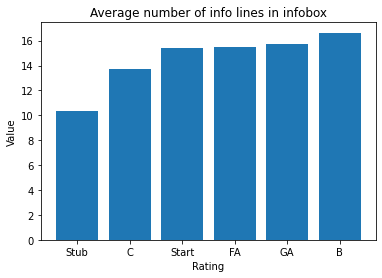

In [ ]:
from pyspark.sql import functions as F
nb_info_items_min_mean_max_df = full_df.groupBy("rating").agg(F.min(full_df.nb_info_items), F.avg(full_df.nb_info_items), F.max(full_df.nb_info_items)).orderBy("avg(nb_info_items)")
# nb_info_items_min_mean_max_df.toPandas()
_nb_info_items_mean = nb_info_items_min_mean_max_df.select("rating", "avg(nb_info_items)").collect()
plot_histogram(_nb_info_items_mean, title="Average number of info lines in infobox", xlabel="Rating", ylabel="Value")

In [ ]:
# !tar cvf histograms.tar *.png

**Average number of paragraphs in the lead section**

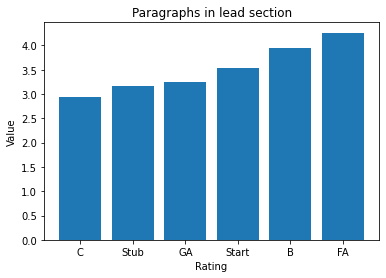

In [ ]:
from pyspark.sql import functions as F
nb_lead_paragraphs_min_mean_max_df = full_df.groupBy("rating").agg(F.min(full_df.nb_lead_paragraphs), F.avg(full_df.nb_lead_paragraphs), F.max(full_df.nb_lead_paragraphs)).orderBy("avg(nb_lead_paragraphs)")
# nb_lead_paragraphs_min_mean_max_df.toPandas()
_nb_lead_paragraphs_mean = nb_lead_paragraphs_min_mean_max_df.select("rating", "avg(nb_lead_paragraphs)").collect()
plot_histogram(_nb_lead_paragraphs_mean, title="Paragraphs in lead section", xlabel="Rating", ylabel="Value")

In [ ]:
# articles_ordered_ = full_df.select("article_revid", "rating", full_df.features[1]).orderBy("article_revid")
# articles_ordered_.show(10)
# articles_ordered = articles_ordered_.collect()

In [ ]:
# import matplotlib.pyplot as plt
# def rating_to_int(rating: str):
#   if rating.lower() == 'stub': return 0
#   elif rating.lower() == 'start': return 1
#   elif rating.lower() == 'c': return 2
#   elif rating.lower() == 'b': return 3
#   elif rating.lower() == 'ga': return 4
#   elif rating.lower() == 'fa': return 5
#   else: return 6
# x = [row[0] for row in articles_ordered]
# y = [row[2] for row in articles_ordered]
# c = [rating_to_int(row[1]) for row in articles_ordered]

# plt.figure(figsize=(25, 10))
# # plt.scatter(list(range(0, 100)), list(range(0, 100)), c=list(range(0, 100)))
# plt.scatter(x, y, c=c, cmap="viridis_r")
# plt.savefig("scatter_plot.png")
# plt.show()

In [ ]:
full_df.toPandas()

,article_pageid,article_revid,automated_readability_index,avg_word,coleman_liau_index,content_length,dale_chall_readability_score,difficult_words,features,flesch_kincaid_grade,...,num_lv2_headings,num_lv3_headings,num_page_links,num_references,quality,rating,smog_index,talk_pageid,talk_revid,words_per_sent
0,5659173,292565216,24.6,6.07,17.63,7.331060,11.93,24.0,"[7.3310603052186325, 258.0, 0.0, 0.0, 2.0, 0.0...",11.2,...,1.0,0.0,0.0,0.000000,Low,Stub,13.6,6660351,292565249,17.2
1,6527950,322687528,33.2,7.38,25.52,6.791221,17.51,30.0,"[6.7912214627261855, 98.0, 0.0, 0.0, 1.0, 0.0,...",17.1,...,2.0,0.0,0.0,0.000000,Low,Stub,16.2,15052702,335002955,20.3
2,14944697,210660341,19.3,6.32,18.19,10.497312,8.99,693.0,"[10.497311511801287, 4351.0, 0.0, 3.0, 9.0, 8....",8.7,...,10.0,0.0,3.0,0.000000,High,GA,10.5,15073677,210721596,10.9
3,14522648,417346976,23.3,6.57,20.53,8.675051,10.99,167.0,"[8.675051276031818, 845.0, 0.0, 0.0, 12.0, 0.0...",13.3,...,4.0,4.0,0.0,0.000000,Low,Start,14.9,14523729,420631809,16.6
4,14092063,329594952,38.6,7.98,29.30,6.395262,13.33,18.0,"[6.395261598115449, 59.0, 0.0, 0.0, 5.0, 0.0, ...",27.0,...,1.0,0.0,0.0,0.000000,Low,Stub,0.0,26671019,351595900,27.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32455,26064275,341886836,39.1,8.81,33.52,7.082549,18.45,38.0,"[7.0825485693553, 400.0, 1.0986122886681098, 1...",17.1,...,2.0,0.0,1.0,1.098612,Low,Stub,16.2,26075205,342033449,17.3
32456,49797375,710247413,39.6,8.86,34.40,8.295299,13.20,92.0,"[8.29529885950246, 668.0, 0.0, 0.0, 5.0, 0.0, ...",20.0,...,4.0,0.0,0.0,0.000000,Low,Stub,15.7,49797435,710247471,24.6
32457,59385,277080523,22.0,6.60,20.41,11.149355,9.80,1728.0,"[11.14935537548599, 8353.0, 0.0, 1.0, 10.0, 2....",12.8,...,10.0,12.0,1.0,0.000000,High,FA,13.5,363327,277080543,15.2
32458,1540309,60693022,17.3,5.40,14.04,10.180437,8.44,533.0,"[10.180437238408865, 3827.0, 2.564949357461536...",11.0,...,8.0,0.0,3.0,2.564949,High,FA,13.0,1540342,61207458,19.8


**Training models**

In [ ]:
# import os
# from pyspark.sql.dataframe import DataFrame
# from pyspark.sql.types import StructField, StringType, StructType, IntegerType, DoubleType, ArrayType

# schema = StructType([ \
#     StructField("index", IntegerType(), True), \
#     StructField("article_revid",StringType(),True), \
#     StructField("features", ArrayType(DoubleType()),True), \
#     # StructField("rating",StringType(),True), \
#   ] + [StructField(field_name, DoubleType(), True) for field_name in features_list])

# def build_text_df():
#   data = []
#   for index, file_name in enumerate(os.listdir("revisiondata")):
#     features = extract_text_data_features_todf(extract_file_text_data(f"revisiondata/{file_name}"))
#     # rating = training_rating_df.filter(training_rating_df.article_revid==file_name).select(["rating"]).collect()
#     # rating = rating[0] if rating else None
#     row = []
#     row.append(index)
#     row.append(file_name)
#     row.append(features)
#     # row.append('rating')

#     for value in features:
#       row.append(value)

#     data.append(row)

#   # print(data[:5])

#   return spark.createDataFrame(data, schema=schema)

In [ ]:
from pyspark.ml.feature import StringIndexer
def build_complete_df(df, rating_df):
  """
  Returns the complete dataset with all features and ratings
  """
  out_df = df.join(rating_df, df.article_revid==rating_df.article_revid).select(["index", df.article_revid, "article_pageid", "talk_pageid", "talk_revid", rating_df.rating, "features"] + features_list)
  return out_df

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
def build_pipeline_model(df):
  """
  Preprocessing pipeline
  """
  stringIndexer = StringIndexer(inputCol="rating", outputCol="label")
  qualityStringIndexer = StringIndexer(inputCol="quality", outputCol="qualityLabel")
  vectorAssembler = VectorAssembler(inputCols=features_list, outputCol="assembledFeatures")
  return Pipeline(stages=[stringIndexer, qualityStringIndexer, vectorAssembler]).fit(df)

def build_learning_pipeline(pipelineModel, learningModel):
  """
  Complete pipeline with learning model
  """
  return Pipeline(stages=[pipelineModel, learningModel])

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
def evaluate_accuracy(predictions, binary=False):
  """
  Accuracy
  """
  evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="qualityLabel" if binary else "label")
  return evaluator.evaluate(predictions)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def print_classification_report(y_true, y_pred, labels=[]):
  """
  Classification report
  """
  print(classification_report(y_true, y_pred, target_names=labels))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred, labels=[], classes=[]):
    """
    Confusion matrix
    """
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure()

    cmap=plt.cm.Reds

    print(matrix)

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # fmt = '.2f'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    plt.show()

## **Classification**

In [ ]:
pipelineModel = build_pipeline_model(full_df)

In [ ]:
fdf = pipelineModel.transform(full_df)
print(fdf.select(["label", "rating", "quality", "qualityLabel"]).groupBy("rating").count().orderBy("count", ascending=False).collect())
print(fdf.select(["label", "rating", "quality", "qualityLabel"]).groupBy("label").count().orderBy("label").collect())

[Row(rating='GA', count=5497), Row(rating='Stub', count=5493), Row(rating='B', count=5492), Row(rating='C', count=5492), Row(rating='Start', count=5490), Row(rating='FA', count=4996)]
[Row(label=0.0, count=5497), Row(label=1.0, count=5493), Row(label=2.0, count=5492), Row(label=3.0, count=5492), Row(label=4.0, count=5490), Row(label=5.0, count=4996)]


Random forest classifier

In [ ]:
import datetime
# Random forest classfier
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, NaiveBayes, GBTClassifier
rf = RandomForestClassifier(featuresCol="assembledFeatures", labelCol="label")
t = datetime.datetime.now()
# rfModel = build_learning_pipeline(pipelineModel, rf).fit(training_df)
rfModel = pipelineModel.load("/content/drive/MyDrive/Big data project/rfModel1")
print("RandomForestClassifier training time is =", (datetime.datetime.now() - t))

RandomForestClassifier training time is = 0:00:14.807999


In [ ]:
t = datetime.datetime.now()
rfPredictions = rfModel.transform(testing_df)
print("RandomForestClassifier prediction time is =", (datetime.datetime.now() - t))
print("Accuracy is", evaluate_accuracy(rfPredictions, binary=False))
y_true = rfPredictions.select(['label']).collect()
y_pred = rfPredictions.select(['prediction']).collect()
print_classification_report(y_true, y_pred, ['GA', "Stub", 'B', "C", 'Start', 'FA'])

RandomForestClassifier prediction time is = 0:00:00.261692
Accuracy is 0.5269607387660782
              precision    recall  f1-score   support

          GA       0.46      0.43      0.45       549
        Stub       0.82      0.86      0.84       579
           B       0.45      0.22      0.29       547
           C       0.41      0.34      0.37       556
       Start       0.52      0.62      0.57       551
          FA       0.52      0.82      0.64       504

    accuracy                           0.55      3286
   macro avg       0.53      0.55      0.53      3286
weighted avg       0.53      0.55      0.53      3286



[[0.428051   0.00182149 0.05100182 0.12204007 0.02367942 0.37340619]
 [0.         0.8566494  0.00518135 0.00172712 0.13644214 0.        ]
 [0.15904936 0.01096892 0.21937843 0.21937843 0.18647166 0.2047532 ]
 [0.17985612 0.01978417 0.14568345 0.33633094 0.2176259  0.10071942]
 [0.03085299 0.16333938 0.0399274  0.12704174 0.62431942 0.01451906]
 [0.13492063 0.         0.0297619  0.01388889 0.         0.82142857]]


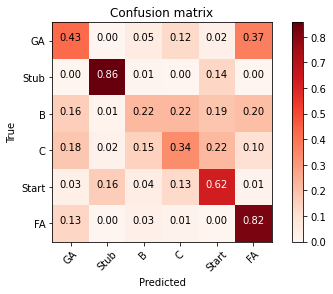

In [ ]:
show_confusion_matrix(y_true, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], classes=['GA', "Stub", 'B', "C", 'Start', 'FA'])

In [ ]:
# persisting model
# rfModel.save("/content/drive/MyDrive/Big data project/rfModel1")

Logistic regression

In [ ]:
# Logistic regression classifier
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, NaiveBayes, GBTClassifier
lr = LogisticRegression(featuresCol="assembledFeatures", labelCol="label")
t = datetime.datetime.now()
# lrModel = build_learning_pipeline(pipelineModel, lr).fit(training_df)
lrModel = pipelineModel.load("/content/drive/MyDrive/Big data project/lrModel1")
print("LogisticRegression training time is =", (datetime.datetime.now() - t))

LogisticRegression training time is = 0:00:10.397811


In [ ]:
t = datetime.datetime.now()
lrPredictions = rfModel.transform(testing_df)
print("LogisticRegression prediction time is =", (datetime.datetime.now() - t))
print(evaluate_accuracy(lrPredictions, binary=False))
y_true = lrPredictions.select(['label']).collect()
y_pred = lrPredictions.select(['prediction']).collect()
print_classification_report(y_true, y_pred, ['FA', "GA", 'B', "C", 'Start', 'Stun'])

LogisticRegression prediction time is = 0:00:00.307322
0.5269607387660782
              precision    recall  f1-score   support

          FA       0.46      0.43      0.45       549
          GA       0.82      0.86      0.84       579
           B       0.45      0.22      0.29       547
           C       0.41      0.34      0.37       556
       Start       0.52      0.62      0.57       551
        Stun       0.52      0.82      0.64       504

    accuracy                           0.55      3286
   macro avg       0.53      0.55      0.53      3286
weighted avg       0.53      0.55      0.53      3286



[[0.428051   0.00182149 0.05100182 0.12204007 0.02367942 0.37340619]
 [0.         0.8566494  0.00518135 0.00172712 0.13644214 0.        ]
 [0.15904936 0.01096892 0.21937843 0.21937843 0.18647166 0.2047532 ]
 [0.17985612 0.01978417 0.14568345 0.33633094 0.2176259  0.10071942]
 [0.03085299 0.16333938 0.0399274  0.12704174 0.62431942 0.01451906]
 [0.13492063 0.         0.0297619  0.01388889 0.         0.82142857]]


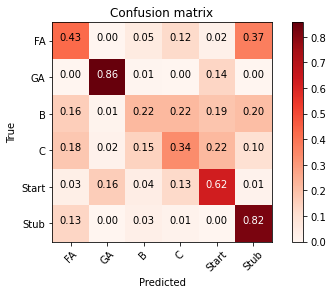

In [ ]:
show_confusion_matrix(y_true, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], classes=['FA', "GA", 'B', "C", 'Start', 'Stub'])

In [ ]:
# persisting model
# lrModel.save("/content/drive/MyDrive/Big data project/lrModel1")

Decision tree

In [ ]:
# Logistic regression classifier
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, NaiveBayes, GBTClassifier
dt = DecisionTreeClassifier(featuresCol="assembledFeatures", labelCol="label")
t = datetime.datetime.now()
# dtModel = build_learning_pipeline(pipelineModel, dt).fit(training_df)
dtModel = pipelineModel.load("/content/drive/MyDrive/Big data project/dtModel1")
print("DecisionTreeClassifier training time is =", (datetime.datetime.now() - t))

DecisionTreeClassifier training time is = 0:00:10.241399


In [ ]:
t = datetime.datetime.now()
dtPredictions = dtModel.transform(testing_df)
print("DecisionTreeClassifier prediction time is =", (datetime.datetime.now() - t))
print(evaluate_accuracy(dtPredictions, binary=False))
y_true = dtPredictions.select(['label']).collect()
y_pred = dtPredictions.select(['prediction']).collect()
print_classification_report(y_true, y_pred, ['FA', "GA", 'B', "C", 'Start', 'Stun'])

DecisionTreeClassifier prediction time is = 0:00:00.223858
0.521390394067747
              precision    recall  f1-score   support

          FA       0.41      0.48      0.44       549
          GA       0.83      0.82      0.82       579
           B       0.47      0.22      0.30       547
           C       0.39      0.31      0.35       556
       Start       0.51      0.62      0.56       551
        Stun       0.55      0.78      0.65       504

    accuracy                           0.54      3286
   macro avg       0.53      0.54      0.52      3286
weighted avg       0.53      0.54      0.52      3286



[[0.47723133 0.00182149 0.0564663  0.12750455 0.01457195 0.32240437]
 [0.00518135 0.82037997 0.00345423 0.00690846 0.16234888 0.00172712]
 [0.21389397 0.01279707 0.22120658 0.20658135 0.18464351 0.16087751]
 [0.25179856 0.01798561 0.12230216 0.3147482  0.21582734 0.07733813]
 [0.04355717 0.14519056 0.04174229 0.13974592 0.61887477 0.01088929]
 [0.18055556 0.         0.0297619  0.01388889 0.         0.77579365]]


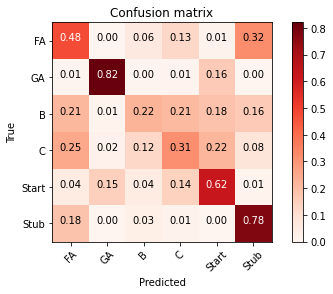

In [ ]:
show_confusion_matrix(y_true, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], classes=['FA', "GA", 'B', "C", 'Start', 'Stub'])

In [ ]:
# persisting model
# dtModel.save("/content/drive/MyDrive/Big data project/dtModel1")

**Binary classifiers**

Gradient boost classifier

In [ ]:
# Gradient boost classifier
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, NaiveBayes, GBTClassifier
gbt = GBTClassifier(featuresCol="assembledFeatures", labelCol="qualityLabel", maxIter=50)  # Binary classifier
t = datetime.datetime.now()
# gbtModel = build_learning_pipeline(pipelineModel, gbt).fit(training_df)
gbtModel = pipelineModel.load("/content/drive/MyDrive/Big data project/gbtModel1")
print("GBTClassifier binary training time is =", (datetime.datetime.now() - t))

GBTClassifier binary training time is = 0:00:11.252064


In [ ]:
t = datetime.datetime.now()
gbtPredictions = gbtModel.transform(testing_df)
print("GBTClassifier binary prediction time is =", (datetime.datetime.now() - t))
print(evaluate_accuracy(gbtPredictions, binary=True))
y_true = gbtPredictions.select(['qualityLabel']).collect()
y_pred = gbtPredictions.select(['prediction']).collect()
print_classification_report(y_true, y_pred, ['Low', "High"])

GBTClassifier binary prediction time is = 0:00:00.210362
0.8889184347836805
              precision    recall  f1-score   support

         Low       0.92      0.91      0.92      2233
        High       0.82      0.84      0.83      1053

    accuracy                           0.89      3286
   macro avg       0.87      0.87      0.87      3286
weighted avg       0.89      0.89      0.89      3286



[[0.91312136 0.08687864]
 [0.16334283 0.83665717]]


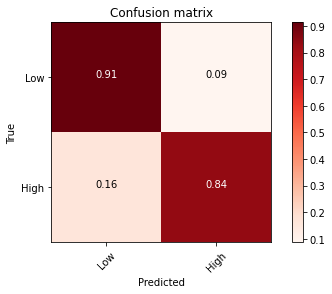

In [ ]:
show_confusion_matrix(y_true, y_pred, labels=[0.0, 1.0], classes=['Low', "High"])

In [ ]:
# persisting model
# gbtModel.save("/content/drive/MyDrive/Big data project/gbtModel1")

Logistic regression

In [ ]:
# Logistic regression classifier
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, NaiveBayes, GBTClassifier
lrB = LogisticRegression(featuresCol="assembledFeatures", labelCol="qualityLabel", maxIter=50)  # Binary classifier
t = datetime.datetime.now()
# lrBModel = build_learning_pipeline(pipelineModel, lrB).fit(training_df)
lrBModel = pipelineModel.load("/content/drive/MyDrive/Big data project/lrBModel1")
print("LogisticRegression binary training time is =", (datetime.datetime.now() - t))

LogisticRegression binary training time is = 0:00:09.888691


In [ ]:
t = datetime.datetime.now()
lrBPredictions = lrBModel.transform(testing_df)
print("LogisticRegression binary prediction time is =", (datetime.datetime.now() - t))
print(evaluate_accuracy(lrBPredictions, binary=True))
y_true = lrBPredictions.select(['qualityLabel']).collect()
y_pred = lrBPredictions.select(['prediction']).collect()
print_classification_report(y_true, y_pred, ['Low', "High"])

LogisticRegression binary prediction time is = 0:00:00.184880
0.8696185758032118
              precision    recall  f1-score   support

         Low       0.90      0.91      0.90      2233
        High       0.80      0.79      0.80      1053

    accuracy                           0.87      3286
   macro avg       0.85      0.85      0.85      3286
weighted avg       0.87      0.87      0.87      3286



In [ ]:
# persisting model
# lrBModel.save("/content/drive/MyDrive/Big data project/lrBModel1")

Random forest

In [ ]:
# Random forest classifier
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, NaiveBayes, GBTClassifier
rfB = RandomForestClassifier(featuresCol="assembledFeatures", labelCol="qualityLabel")  # Binary classifier
t = datetime.datetime.now()
# rfBModel = build_learning_pipeline(pipelineModel, rfB).fit(training_df)
rfBModel = pipelineModel.load("/content/drive/MyDrive/Big data project/rfBModel1")
print("RandomForestClassifier binary training time is =", (datetime.datetime.now() - t))

RandomForestClassifier binary training time is = 0:00:11.568479


In [ ]:
t = datetime.datetime.now()
rfBPredictions = rfBModel.transform(testing_df)
print("RandomForestClassifier binary prediction time is =", (datetime.datetime.now() - t))
print(evaluate_accuracy(rfBPredictions, binary=True))
y_true = rfBPredictions.select(['qualityLabel']).collect()
y_pred = rfBPredictions.select(['prediction']).collect()
print_classification_report(y_true, y_pred, ['Low', "High"])

RandomForestClassifier binary prediction time is = 0:00:00.133874
0.8542239113451024
              precision    recall  f1-score   support

         Low       0.89      0.90      0.89      2233
        High       0.79      0.75      0.77      1053

    accuracy                           0.86      3286
   macro avg       0.84      0.83      0.83      3286
weighted avg       0.85      0.86      0.85      3286



In [ ]:
# persisting model
# rfBModel.save("/content/drive/MyDrive/Big data project/rfBModel1")